# Power of Graph Products
In this notebook we will explore the power of graph products. We will use the following graph products:
* Cartesian product
* Strong product
* Tensor product
* Modular product
* Lexicographic product

We will explore the use of different embeddings and the effect of different graph products on the embeddings.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

from compare import compare_embeddings as compare
from cycle_counting import embed_graph_cycles as cycles
from weisfeiler_lehman import embed_graph_wl as wl
from product import get_all_products
from product import PRODUCTS as available_products
from visual import plot_horizontally as plot, save_pdf
from utils import results_to_latex

We will start by using all possible non-isomorphic graphs with a maximum of 7 nodes that are connected. This gives us a total of 995 graphs.

In [2]:
Gs = [G for G in nx.graph_atlas_g() if not nx.is_empty(G) and nx.is_connected(G)]
len(Gs)

995

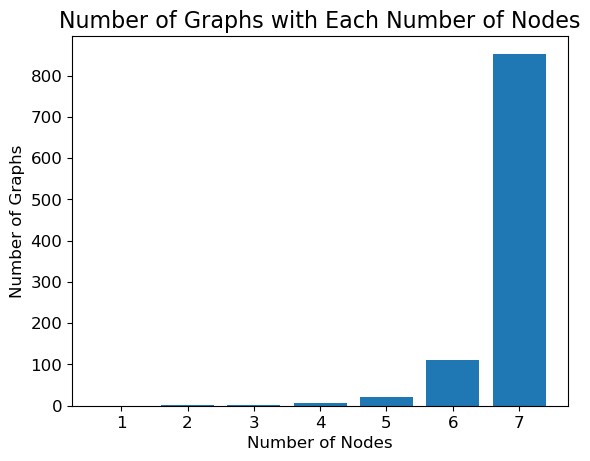

In [3]:
number_of_graphs_with_n_nodes = [len([G for G in Gs if G.number_of_nodes() == i]) for i in range(1, 8)]
plt.bar(range(1, 8), number_of_graphs_with_n_nodes)
plt.xlabel("Number of Nodes", fontsize=12)
plt.ylabel("Number of Graphs", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Number of Graphs with Each Number of Nodes", fontsize=16)
save_pdf(plt, 'graph_node_distribution')
plt.show()

## Preprocessing
We will start by assembeling all the graphs and graph products in a structured manner to make it easier to analyze different embedding methods. Furthermore we will create different categorical labels for the graphs. 

### Factor graphs
Using different factor graphs could change the embedding, and therefore the effect of the graph products. We will use the following factor graphs:
* Complete graph
* Path graph
* Star graph

Regarding the size of the factor graphs, we will use the following sizes:
* 3 nodes
* 5 nodes
* 7 nodes

In [4]:
use_subset = True

factor_graphs = {
    'K3': nx.complete_graph(3),
    'K5': nx.complete_graph(5),
    'K7': nx.complete_graph(7),
    'K9': nx.complete_graph(9),
    'K11': nx.complete_graph(11),
    'K13': nx.complete_graph(13),
    'K15': nx.complete_graph(15),
    'P3': nx.path_graph(3),
    'P5': nx.path_graph(5),
    'P7': nx.path_graph(7),
    'P9': nx.path_graph(9),
    'P11': nx.path_graph(11),
    'P13': nx.path_graph(13),
    'P15': nx.path_graph(15),
    'S3': nx.star_graph(3),
    'S5': nx.star_graph(5),
    'S7': nx.star_graph(7),
    'S9': nx.star_graph(9),
    'S11': nx.star_graph(11),
    'S13': nx.star_graph(13),
    'S15': nx.star_graph(15),
}

if use_subset:
    sizes = [3, 5, 7, 13]
    factor_graphs = {k: v for k, v in factor_graphs.items() if int(k[1:]) in sizes}

factor_graphs

{'K3': <networkx.classes.graph.Graph at 0x7f765abd9f90>,
 'K5': <networkx.classes.graph.Graph at 0x7f765ac27110>,
 'K7': <networkx.classes.graph.Graph at 0x7f765ac27790>,
 'K13': <networkx.classes.graph.Graph at 0x7f765ac1a310>,
 'P3': <networkx.classes.graph.Graph at 0x7f765ad42ad0>,
 'P5': <networkx.classes.graph.Graph at 0x7f765ac16550>,
 'P7': <networkx.classes.graph.Graph at 0x7f765ac16950>,
 'P13': <networkx.classes.graph.Graph at 0x7f765ac17ed0>,
 'S3': <networkx.classes.graph.Graph at 0x7f765d9f5bd0>,
 'S5': <networkx.classes.graph.Graph at 0x7f765ac11e50>,
 'S7': <networkx.classes.graph.Graph at 0x7f765ac12410>,
 'S13': <networkx.classes.graph.Graph at 0x7f765ac13bd0>}

### Graph products
Now we will create the graph products of the factor graphs with all the graphs considered.

In [5]:
graph_products = pd.DataFrame(index=factor_graphs.keys(), columns=available_products)
graph_products.index.name = 'Factor Graph'
graph_products.columns.name = 'Graph Product'

for factor_name in factor_graphs:
    FG = factor_graphs[factor_name]
    products = get_all_products(Gs, FG)
    
    for product_name in products:
        graph_products.loc[factor_name, product_name] = products[product_name]

### Categorical Labels
We will create categorical labels for the graphs. The labels will be based on:
* Number of nodes
* Number of edges
* Highest degree

In [6]:
num_nodes = np.array([G.number_of_nodes() for G in Gs])
num_edges = np.array([G.number_of_edges() for G in Gs])
highest_degree = np.array([max(dict(G.degree()).values()) for G in Gs])

node_normalized_highest_degree = highest_degree / num_nodes
edge_normalized_highest_degree = highest_degree / num_edges

## Cycle counting
We will use the cycle counting method by preparing embedding each graph using a vector, where each entry contains the number of cycles of a certain length (the length is the index of the entry). We will then use different graph products and observe, how the cycle counts change.

### Embeddings
For all these graph products, as well as the initial graphs, we will create embeddings by counting cycles of different lengths. We will use an embedding size of 7*7=49, which is the maximum length of cycles in a graph product of two graphs with each 7 nodes.

In [7]:
cycle_embedded_graphs = cycles(Gs, 49)
cycle_embedded_products = graph_products.map(lambda x: cycles(x, 49))

### Evaluation and Comparison
In this section, we will evaluate, how many graphs, that are isomorphic to each other, are mapped to the same embedding. We will also compare the embeddings of the different graph products.

In [8]:
cycle_results = compare(cycle_embedded_graphs, index=True)
cycle_product_results = cycle_embedded_products.map(lambda x: compare(x, index=True))

In [9]:
print("Number of non-isomorphic graphs with the same embedding: {}".format(cycle_results[0]))

Number of non-isomorphic graphs with the same embedding: 14239


In [10]:
results_to_latex(cycle_product_results.map(lambda x: x[0])) # construct latex table for report
cycle_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,1096,11795,255,283,12742
K5,1040,9086,108,123,9977
K7,1039,9086,96,112,9977
K13,1039,9086,95,112,9977
P3,1407,787,7311,36,3299
P5,1404,33,549,7,3057
P7,1404,11,121,7,3057
P13,1404,5,49,5,3057
S3,191,1987,7263,72,4226


To further understand the different impact of different graph products, we will take the row-wise intersection, to see, how many graphs can not be distinguished, after using all the different graph products.

In [11]:
cycle_product_results.map(lambda x: x[1]).apply(lambda x: len(set.intersection(*x)), axis=1)

Factor Graph
K3     63
K5     26
K7     24
K13    24
P3      1
P5      0
P7      0
P13     0
S3      1
S5      1
S7      1
S13     1
dtype: int64

Next we will analyze if there are any pairs of graphs, that have the same embedding after a graph product, but not before. This would mean, that the graph product has worsened the embedding for this specific case.

In [12]:
cycle_product_results.map(lambda x: len(x[1] - cycle_results[1]))

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,48,5210,29,45,4978
K5,10,2520,9,25,2226
K7,11,2520,6,24,2226
K13,11,2520,6,24,2226
P3,257,158,4648,14,1124
P5,255,3,201,2,903
P7,255,0,22,4,903
P13,255,0,5,2,903
S3,33,872,4612,49,2008


### Visualization
Seeing the effectiveness of the graph products, we will further investigate the embeddings of them by visualizing them. We will use the following visualization methods:
* Examples of graphs with the same embedding (before and after graph products)
* Examples of graphs with the same embedding (only after graph products)
* Examples of graphs with different embeddings (only after graph products)
* Examples of graphs with same embeddings after various graph products
* t-SNE

In [13]:
original_idx = cycle_results[1]
comparative_idx = cycle_product_results.loc['K7', 'Tensor'][1]

def sort_by_simiplicity(idx_pairs):
    """
    Sorts the index pairs by the combined number of nodes of both graphs.
    This helps to find graphs, that are understandable by humans.
    """
    return sorted(idx_pairs, key=lambda x: (num_nodes[x[0]], num_nodes[x[1]]))

def plot_dual_examples(set_idx_pairs, num_examples=3):
    idx_pairs = list(set_idx_pairs)
    for i in range(num_examples):
        if i >= len(idx_pairs):
            print("Warning: Not enough examples to plot")
            break

        graph_pair = [Gs[idx_pairs[i][0]], Gs[idx_pairs[i][1]]]
        plot(graph_pair, titles=['Graph 1', 'Graph 2'], figsize=(10, 5))

#### Examples of graphs with the same embedding (before and after graph products)

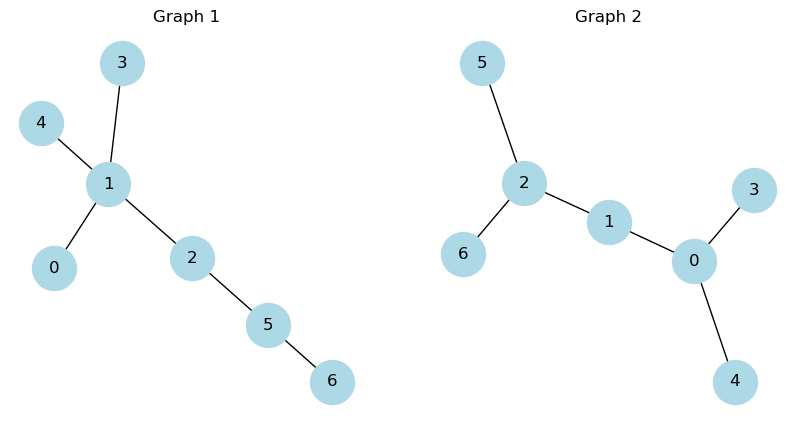

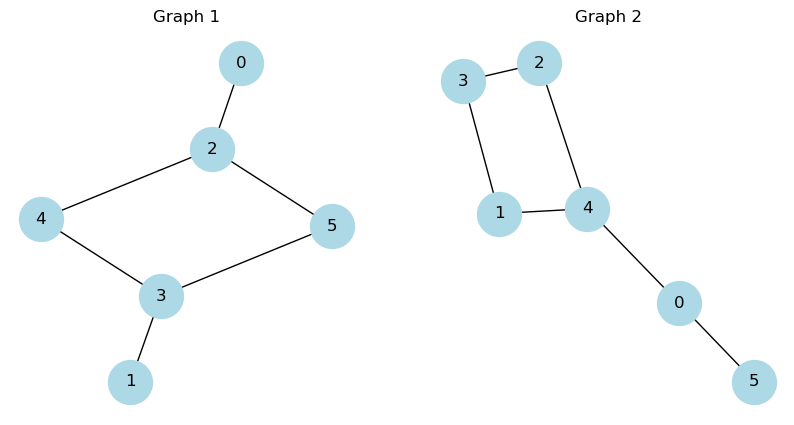

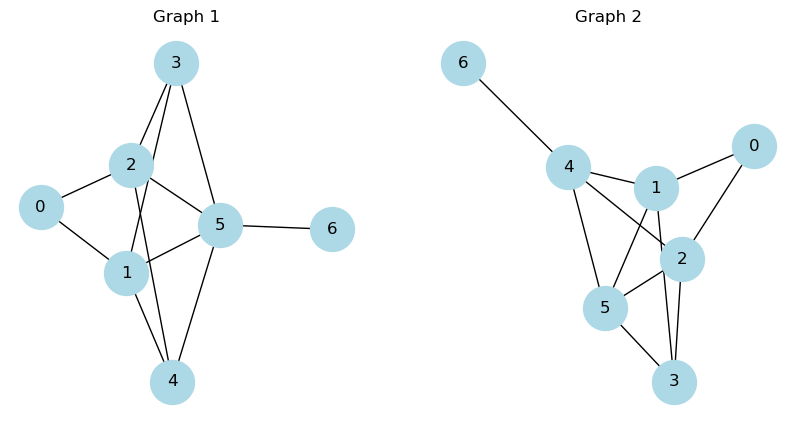

In [14]:
common_idx = original_idx.intersection(comparative_idx)
# common_idx = sort_by_simiplicity(common_idx)

plot_dual_examples(common_idx)

#### Examples of graphs with the same embedding (only after graph products)

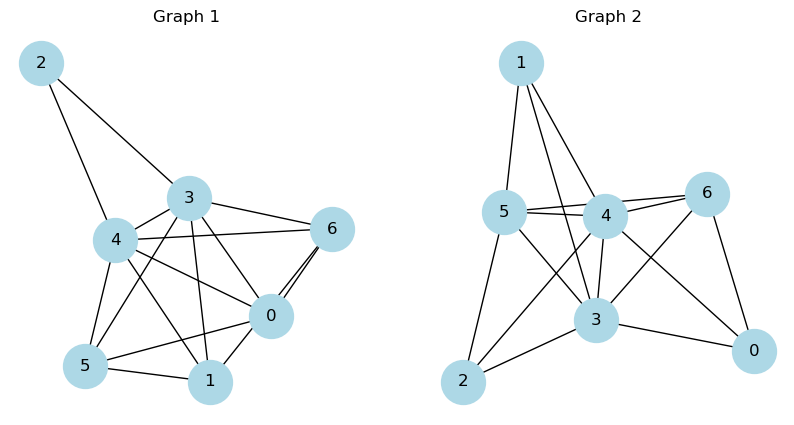

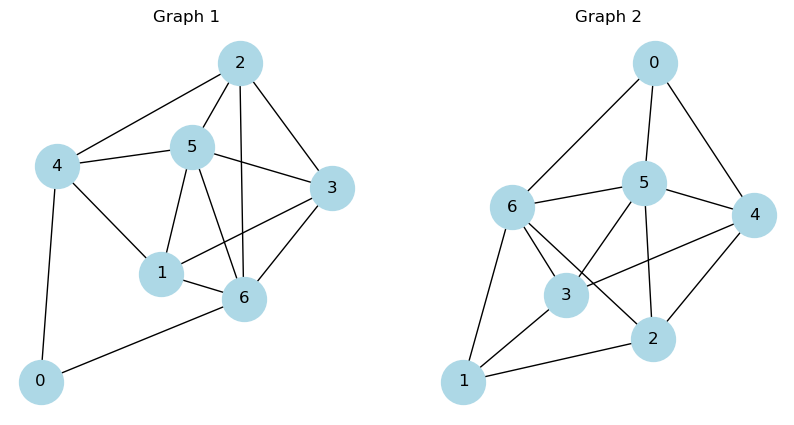

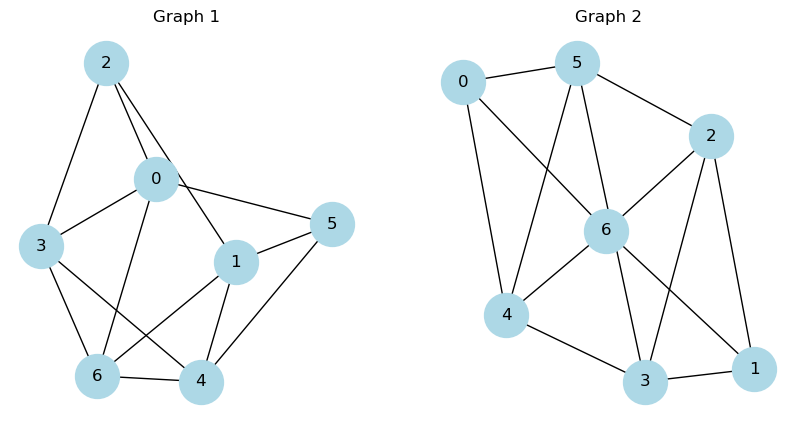

In [15]:
same_only_after_idx = comparative_idx - original_idx
# same_only_after_idx = sort_by_simiplicity(same_only_after_idx)

plot_dual_examples(same_only_after_idx)

#### Examples of graphs with different embeddings (only after graph products)

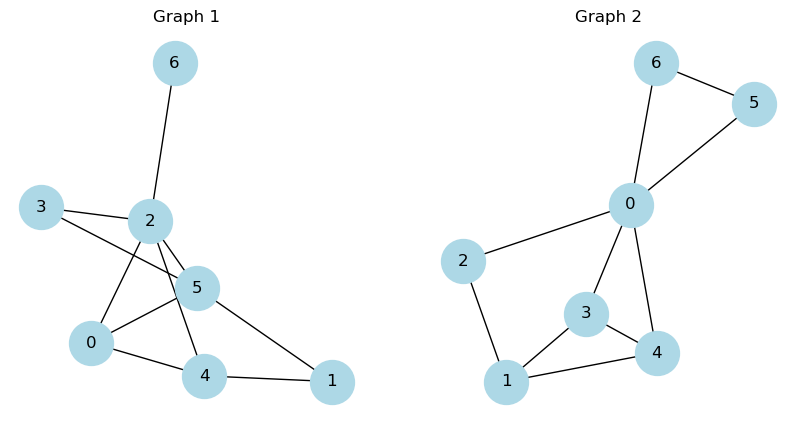

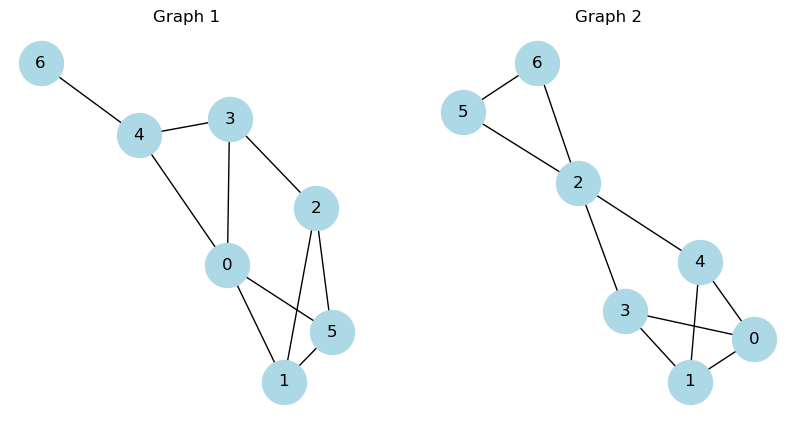

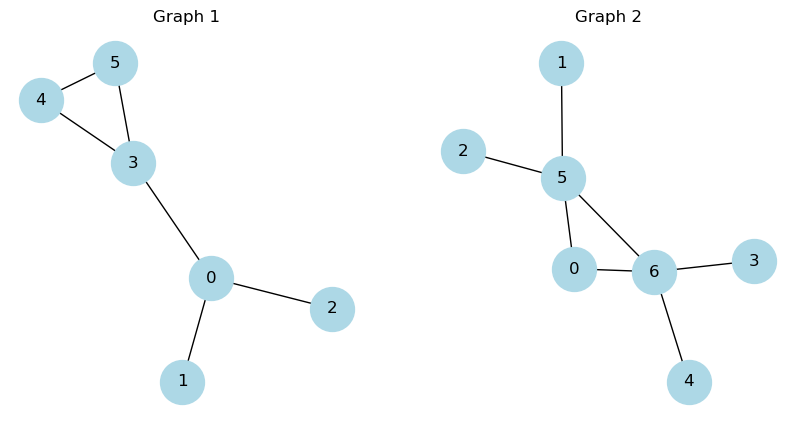

In [16]:
different_only_after_idx = original_idx - comparative_idx
# different_only_after_idx = sort_by_simiplicity(different_only_after_idx)

plot_dual_examples(different_only_after_idx)

#### Examples of graphs with same embeddings after various graph products

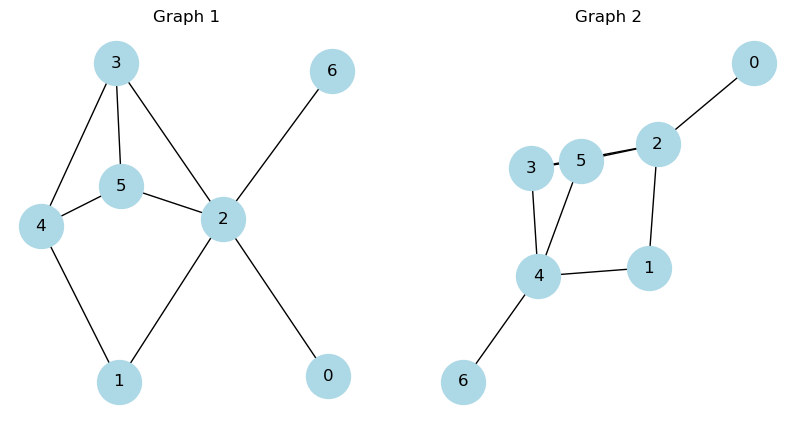

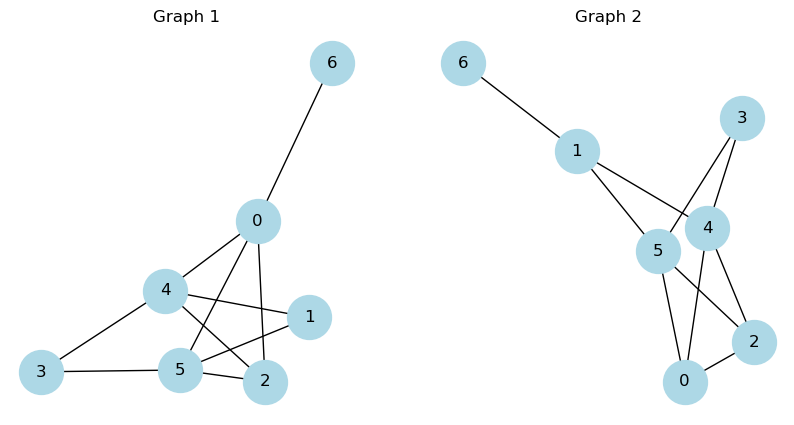

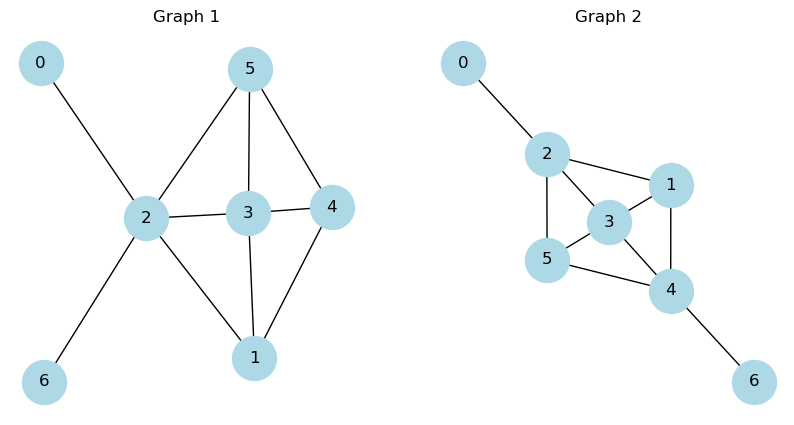

In [17]:
# Change the factor graphs to compare and the graph products to compare
factor_graphs_to_compare = ['K7', 'P7']
graph_products_to_compare = ['Strong', 'Tensor']

similar_for_all_idx = original_idx.intersection(*cycle_product_results.loc[factor_graphs_to_compare, graph_products_to_compare].map(lambda x: x[1]).values.flatten())
# similar_for_all_idx = sort_by_simiplicity(similar_for_all_idx)

plot_dual_examples(similar_for_all_idx)

#### t-SNE
The **T-distibuted Stochastic Neighbor Embedding** (t-SNE) is a dimensionality reduction technique, that is often used for visualizing high-dimensional data. It is a non-linear technique, that is particularly well suited for embedding data into a space of two or three dimensions, which can then be visualized in a scatter plot. Specifically, it models each high-dimensional object in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

We will use t-SNE to visualize the embeddings of the graphs. We employ different color schemes to represent categorical attributes of the graphs, such as the number of nodes, the number of edges, and the highest degree.

In [18]:
# Choose one of the options to be the color mapping for the t-SNE plots
cmap_num_nodes = ("Number of Nodes", num_nodes)
cmap_num_edges = ("Number of Edges", num_edges)
cmap_highest_degree = ("Highest Degree", highest_degree)
cmap_node_normalized_highest_degree = ("Node Normalized Highest Degree", node_normalized_highest_degree)
cmap_edge_normalized_highest_degree = ("Edge Normalized Highest Degree", edge_normalized_highest_degree) 

# Change this variable to change the color mapping
color_mapping = cmap_num_edges

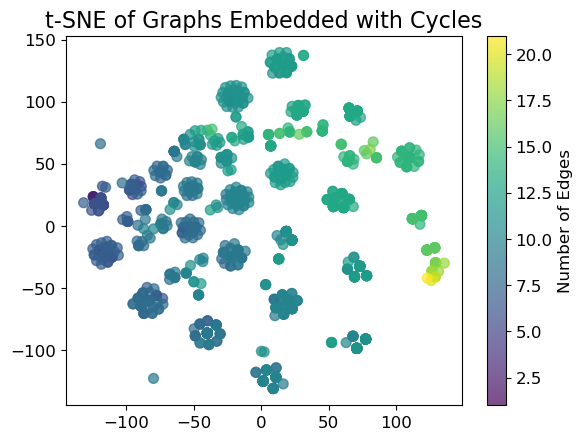

In [19]:
tsne = TSNE(n_components=2)
tsne_graphs = tsne.fit_transform(cycle_embedded_graphs)

sc = plt.scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("t-SNE of Graphs Embedded with Cycles", fontsize=16)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(color_mapping[0], fontsize=12)
save_pdf(plt, 'tsne_original')
plt.show()

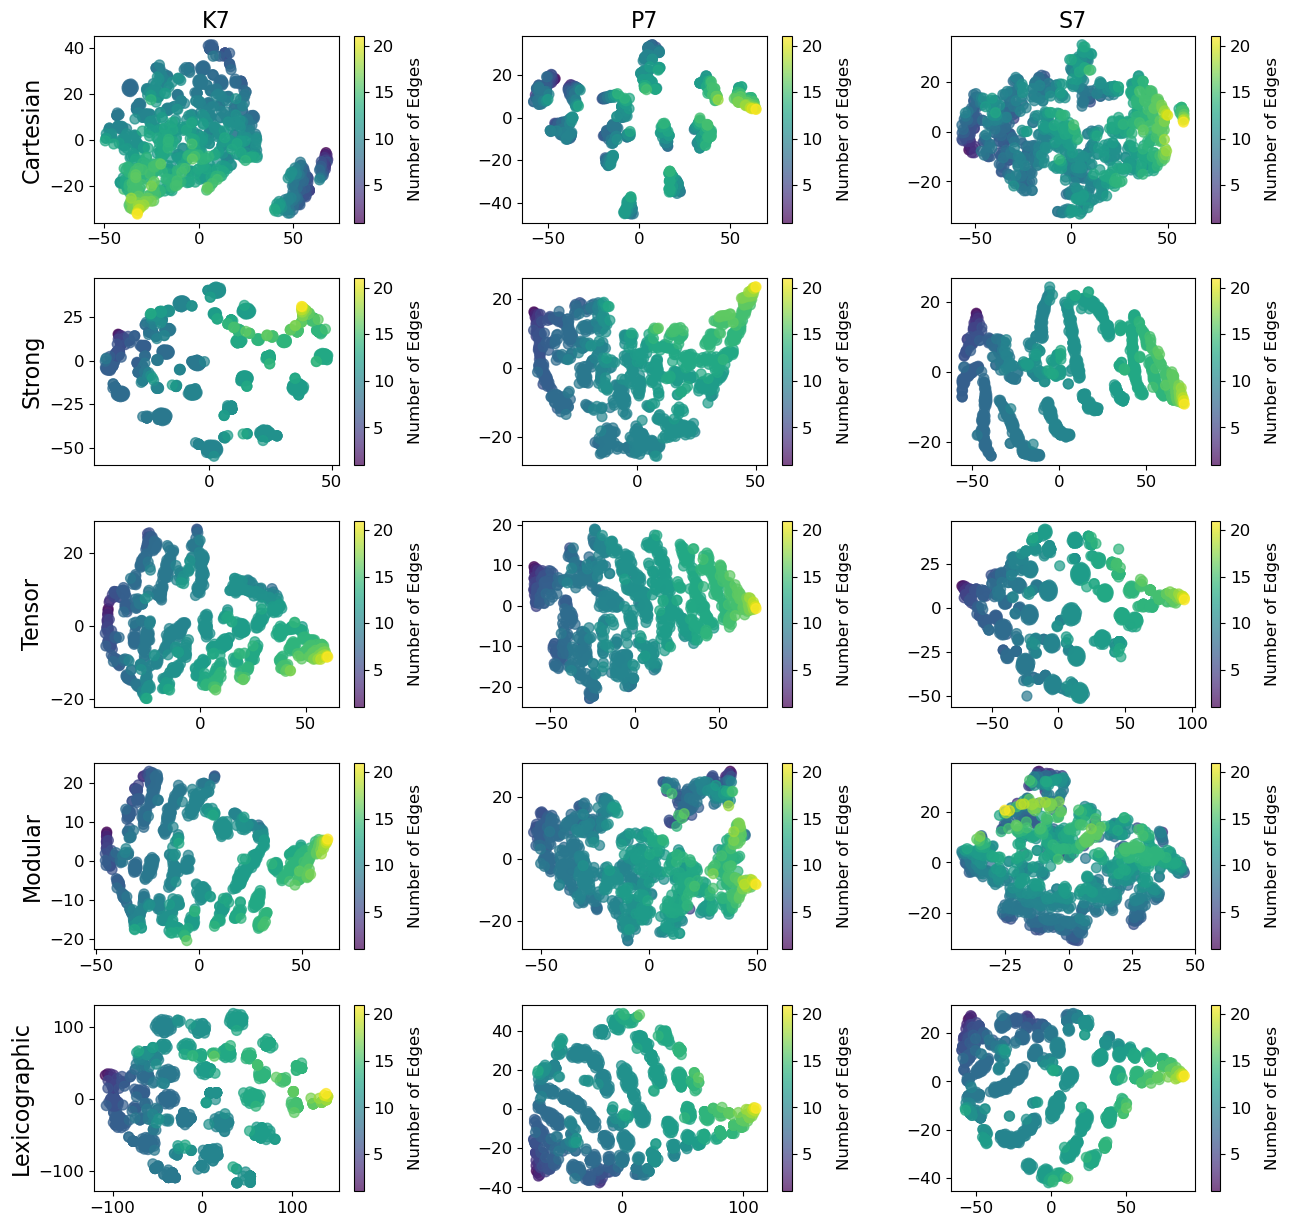

In [20]:
chosen_factor_graphs = ['K7', 'P7', 'S7']

fig, axes = plt.subplots(len(cycle_embedded_products.columns),
                         len(chosen_factor_graphs), 
                         figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for j, factor_graph in enumerate(['K7', 'P7', 'S7']):
    comparative_cycle_embedded_graphs = cycle_embedded_products.loc[factor_graph]
    for i, (product_name, embeddings) in enumerate(comparative_cycle_embedded_graphs.items()):
        tsne = TSNE(n_components=2)
        tsne_graphs = tsne.fit_transform(embeddings)
        sc = axes[i, j].scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=color_mapping[1],
                 cmap='viridis',
                 s=50)
        axes[i, j].tick_params(axis='both', which='major', labelsize=12)

        cbar = plt.colorbar(sc, ax=axes[i, j])
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label(color_mapping[0], fontsize=12, labelpad=10)
    axes[0, j].set_title(factor_graph, fontsize=16)

for i, product_name in enumerate(cycle_embedded_products.columns):
    axes[i, 0].set_ylabel(product_name, fontsize=16)

save_pdf(plt, 'tsne_product')
plt.show()

### Results and Discussion
We will discuss the results of the previous sections and draw conclusions.

Applying the graph products to graphs before embedding them using a cycle counting approach has show to be effective. The number of graphs that are mapped to the same embedding is reduced drastically. Interestingly, we can note the effectiveness of different graph products with specific factor graphs. For example, the tensor product with a complete graph or a path grap as a factor graph is very effective, while the tensor product with a star graph as a factor graph is not very effective. Conversely, the Cartesian product with a star graph as a factor graph is very effective, while the Cartesian product with a complete graph or a path graph as a factor graph is not very effective. The strong product is especially effective with the path graph. 

The combination of the strong graph product with the path graph as a factor graph is the most effective combination. It is able to map all but 5 graph pairs to different embeddings. This is a very good result, even improving upon the results of the Weisfeiler-Lehman algorithm, which has a total of 20 graph pairs that are mapped to the same embedding.

The t-SNE visualization corroborates the results, as described above. We can see that for certain combinations of graph products and factor graphs, the embedding space is evenly separated, whereas for other combinations, there are narrow clusters of embeddings, which indicates that many graphs are mapped to the same embedding.

## Weisfeiler-Lehman
Next will use the standard one dimensional Weisfeiler-Lehman isomorphism test and perform the same evaluations and comparisons as before.

### Embeddings
We will use 10 iterations of the Weisfeiler-Lehman algorithm to create the embeddings.

In [21]:
wl_embedded_graphs = wl(Gs, 10)
wl_embedded_products = graph_products.map(lambda x: wl(x, 10))

### Evaluation and Comparison
In this section, we will evaluate the effectiveness of graph products ability to enhance the WL isomorphism test. 

In [22]:
wl_results = compare(wl_embedded_graphs)
wl_product_results = wl_embedded_products.map(lambda x: compare(x))

In [23]:
wl_results

20

In [24]:
wl_product_results

Graph Product,Cartesian,Strong,Tensor,Modular,Lexicographic
Factor Graph,,,,,
K3,20,20,20,20,20
K5,20,20,20,20,20
K7,20,20,20,20,20
K13,20,20,20,20,20
P3,20,20,20,20,20
P5,20,20,20,20,20
P7,20,20,20,20,20
P13,20,20,20,20,20
S3,20,20,20,20,20


### Conclusion and Discussion
As we can see from the table above, the graph products showed no effect on enhancing the WL isomorphism test.